# Research on people's attitude towards game reviews (running time: 2 minutes）

# Research Background

Nowadays, games have become an indispensable form of entertainment for contemporary teenagers. Different games and different game crowds will cause different evaluations of the game. Game players post their attitude towards the game under the game review module. As a result, what kind of game reviews will be considered valuable reviews? This article selects Steam's comment area as a data source to predict how satisfied people are with a new comment. The reason for choosing the Steam data set is that data from the tracking site Steam Spy (https://steamspy.com/) indicated that Steam currently has 281 million registered accounts worldwide and 17.5 million online users until 2017. The population base is large, and the types of games are diversified, which can represent the game market to a certain extent.

#  Purpose of the article

The purpose of this article is to use the natural language processing of previous years' review data to get the most praised reviews and obtain models. Whenever a new comment appears, this model can be used to predict the final rating of the review.

Firstly, reading the data. The data source is from https://cseweb.ucsd.edu/~jmcauley/datasets.html (Steam Video Game and Bundle Data). The code of how to dealing with the gzip data is from the data source web page

In [1]:
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)
 
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('E:/google/australian_user_reviews.json.gz')

In [2]:
df.head()

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."


In this analysis, we only focuse on the reviews. Thus, select the data we want to use and set up an new dataframe to store the data.

In [3]:
import numpy as np

In [4]:
#get the reviwe coloums
reviews=df.reviews

In [5]:
#change data type to the dataframe
f=[]
for i in reviews:
    for e in i:
        f.append(e)

In [6]:
data=pd.DataFrame(f)

In [7]:
data.head()

,funny,posted,last_edited,item_id,helpful,recommend,review
0,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...
1,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.
2,,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...
3,,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...
4,,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...


In [8]:
data.count()

funny          59305
posted         59305
last_edited    59305
item_id        59305
helpful        59305
recommend      59305
review         59305
dtype: int64

In [9]:
data.loc[data['funny']!=''].count()

funny          8151
posted         8151
last_edited    8151
item_id        8151
helpful        8151
recommend      8151
review         8151
dtype: int64

In [10]:
data.loc[data['last_edited']!=''].count()

funny          6140
posted         6140
last_edited    6140
item_id        6140
helpful        6140
recommend      6140
review         6140
dtype: int64

In [11]:
data.loc[data['helpful']!='No ratings yet'].count()

funny          29137
posted         29137
last_edited    29137
item_id        29137
helpful        29137
recommend      29137
review         29137
dtype: int64

# Preliminary data cleaning

As the data frame shows, because the ratio of useful variables (not empty) in the funny data set (8151/59305) is small, the funny dataset is deleted. On the other hand, there are two variables about the date, the one is the ‘posted’ – posted time, the other is ‘last edited’ – the last modification date. As the count shows, some comments do not have the last modification time, there are many missing values (6140/59305), thus, the posted date is used to measure time, delete the ‘last_edited’ column. At the same time, this analysis only focuses on the game reviews themselves, which is for all game items. In this situation, remove the 'item_id'.

In [12]:
#first, remove the no ratings yet data
#clean the data
data_help=data.loc[data['helpful']!='No ratings yet']
#remove un use column
data_help=data_help.drop(['funny','item_id','last_edited',],axis=1)

In [13]:
data_help.head()

,posted,helpful,recommend,review
3,"Posted June 24, 2014.",15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...
4,"Posted September 8, 2013.",0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...
5,"Posted November 29, 2013.",1 of 4 people (25%) found this review helpful,True,Very fun little game to play when your bored o...
12,"Posted October 14, 2013.",2 of 2 people (100%) found this review helpful,True,This game... is so fun. The fight sequences ha...
13,"Posted July 28, 2012.",1 of 1 people (100%) found this review helpful,True,"Really Really Really Great Game, very good sto..."


#  Extract information through regular expressions

There is two important information in the ‘helpful’ column, the one is the total number of people who commented on whether the review was helpful, the other is the total percentage of people who scored the reviews. In this step, these two variables are separated by adopting the method of regular expression. Python provides libraries about regular expressions’, as a result, import the ‘re’ to process the data. The specific operation is shown in this webpage: https://docs.python.org/3/library/re.html.


In [14]:
import re

According to the data set, the number of people and the percentage do not exceed four digits. Therefore, a function can be set that can handle both variables at the same time. Because the original format is a string, using data.map method to change to the integer format.

In [15]:
#set up a function to filter the variables
def num_help(x,y):
    z=[]
#find out the location of the values and put into the list
    for e in x:
        for i in range(len(e)):
            if e[i]== y:
                z.append(e[i-4]+e[i-3]+e[i-2]+e[i-1])
#change list to str
    str_x=",".join(z)
#find out the values we want
    results =re.findall(r"\d+\.?\d*",str_x)
#change str to int
    results = list(map(int, results))
    return (results)


At the same time, the ‘posted’ date is accurate to the day, this step aims to turn the date into a date in years. The method is the same as the helpful method (Year is expressed in four digits). Because the function was established in the previous step, this step only needs to call back function.

In [16]:
#the year of the posted date
data_help['posted']=num_help(data_help['posted'],'.')

#set up the new coloums to get the count of the percentage of helpfu
data_help['%_help']=num_help(data_help['helpful'],'%')

#the total people for the helful
data_help['num_help'] =num_help(data_help['helpful'],'p')

The maining of new columns are as floolwes: 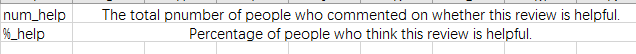

In [17]:
#test the data
data_help.head()

,posted,helpful,recommend,review,%_help,num_help
3,2014,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...,75,20
4,2013,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...,0,1
5,2013,1 of 4 people (25%) found this review helpful,True,Very fun little game to play when your bored o...,25,4
12,2013,2 of 2 people (100%) found this review helpful,True,This game... is so fun. The fight sequences ha...,100,2
13,2012,1 of 1 people (100%) found this review helpful,True,"Really Really Really Great Game, very good sto...",100,1


In [18]:
#test the data
data_help.posted.value_counts()

2014    10920
2015     9069
2013     2927
2012      312
12        222
24        214
3         213
17        206
6         206
4         204
28        204
14        202
27        199
5         197
16        197
1         194
13        194
25        193
29        193
2         192
18        187
23        186
8         185
26        185
19        184
11        182
20        179
9         178
30        171
7         171
15        169
21        165
22        165
10        157
31        102
2011       98
2010       15
Name: posted, dtype: int64

As the value_counts shows, some data does not show the year, but the date. Since the data showing the date is calculated for the current year, the year is not added. The data this analysis used is from 2018, so change the date to 2018.

In [19]:
#because just use for loop of dataframe is too slow, we put them to the list, and add them to the dataframe when data was cleaning
data_posted = np.array(data_help['posted'])
posted=data_posted.tolist()
for i in range(len(posted)):
#find out the location 
    if posted[i] <2000:
        posted[i]=2018

#push the new data to dataframe
data_help['posted']=posted

In [20]:
#test data
data_help.posted.value_counts()

2014    10920
2015     9069
2018     5796
2013     2927
2012      312
2011       98
2010       15
Name: posted, dtype: int64

# Preliminary data processing of decision tree

To consider what kind of reviews are more valuable, delete reviews that people think are not very helpful. The decision tree method is used in this step. 

In [21]:
#cut down the data
data_help=data_help.loc[data_help['%_help']>=50]
data_help=data_help.loc[data_help['num_help']>=5]

#drop the origional helpful column
data_help=data_help.drop('helpful',axis=1)

In [22]:
data_help.count()

posted       4190
recommend    4190
review       4190
%_help       4190
num_help     4190
dtype: int64

Set up an new dataframe to build up the decision tree

In [23]:
data_tree=data_help.drop(['review','posted'],axis=1)

In [24]:
data_tree.head()

,recommend,%_help,num_help
3,True,75,20
18,True,81,43
19,True,75,16
20,True,100,5
22,True,88,8


Cut down the column to set up the decision tree modle. In this step, to balance the recommend true or false value, some selection were made in dataframe.

In [25]:
data_test1=data_tree.loc[data_tree['recommend']==True]
data_test1=data_test1.iloc[0:20]

In [26]:
data_test2=data_tree.loc[data_tree['recommend']==False]
data_test2=data_test2.iloc[0:20]

In [27]:
data_train =data_test1.iloc[0:10].append(data_test2[0:10])

In [28]:
data_test=data_test1.iloc[10:20].append(data_test2[10:20])

Give the overall recommend of each review, 1 means overall recommend, 0 means overall not recommend. The criterion is as followes: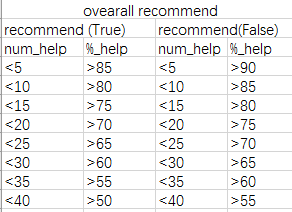

In [29]:
#train overall data
overall_1=[1,1,1,1,1,1,0,0,1,1,0,0,0,0,1,0,1,0,1,1]

#test overall data
overall_2=[0,0,1,1,1,1,0,0,0,0,0,0,1,1,1,1,1,0,0,1]

In [30]:
data_train['overall']=overall_1

In [31]:
data_test['overall']=overall_2

# Build a decision tree

A decision tree is a basic classification and regression method with a tree structure of nodes and directed edges. The nodes have internal nodes and leaf nodes. The internal nodes represent a feature or attribute, and the leaf nodes represent a class. There are three algorithms for feature selection of decision trees: Gini coefficient, information entropy, and information gain.

Gini coefficient reflects the probability that randomly selected samples in the data set are misclassified.

Information entropy reflects the uncertainty of the sample, the greater the information entropy, the greater the uncertainty of the sample.

Information gain is based on information entropy, it calculated the difference between the information entropy of the parent node and the information entropy of the child node.

It is worth noting that, when using information entropy, Scikit-learn calculates the information gain.

Information entropy (in Scikit-learn) is more sensitive to impurity than the Gini Coefficient, as a result when information entropy is used as an indicator, the growth of the decision tree will be ‘finer’. However, for high-dimensional data or noisy data, information entropy is easy to overfit. Because there are fewer variables to make decisions in this analysis, information entropy is used.

Build the model by using scikit-learn, and test the accuracy of the model. The introduction is as follows: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [32]:
from sklearn.tree import DecisionTreeClassifier as DTC

#train the model
x_train = data_train.iloc[:, 0:3]
y_train = data_train.iloc[:, 3]

#test data 
x_test = data_test.iloc[:, 0:3]
y_test = data_test.iloc[:, 3]

#using entropy to measure
clf = DTC(criterion='entropy') 
clf.fit(x_train, y_train)

#get the purity score
score=clf.score(x_test, y_test)
print(score )


0.9


The test purity was 0.9. In Scikit-learn, its default branching method is ‘best’-that is, the optimal solution which leads to the problem of overfitting. To solve the problem, the ‘random’ method is used to process branches. After that,  pruning the branches. The issue of max_depth is involved here. The depth value from 1 to 10 is chosen to test the best depth value. (If the image does not appear, please run it again.)

In [33]:
#test the data to find wheteher there has better soultion
test=[]

for i in range(10):
#get the range of the max_depth in decision tree
    clf = DTC(criterion="entropy",random_state=2,splitter="random",max_depth=i+1)
#fit the value
    clf.fit(x_train,y_train)
    score=clf.score(x_test,y_test)
#change the score to the list
    test.append(score)

import matplotlib.pyplot as plt
#plot the figure
plt.figure(figsize=(20,8),dpi=80)
plt.plot(range(1,11),test)
plt.show()


<Figure size 1600x640 with 1 Axes>

As the graph shows, when the max_depth is 4, purity is the highest, which is 0.05 higher than 0.9. This model is used to process all the review data to get the value of overall recommend (1 for overall recommend and 0 for overall not recommend). 

In [34]:
clf_after = DTC(criterion='entropy',random_state=2,splitter="random",max_depth=4)  
clf_after.fit(x_train, y_train)
score=clf_after.score(x_test, y_test)
print(score )

0.95


Demonstrates the decision process of the decision tree.

In [35]:
from sklearn.tree import export_text
tree_rules = export_text(clf_after, feature_names=['recommend','%_help','num_help'])
print(tree_rules)

|--- num_help <= 18.59
|   |--- recommend <= 0.76
|   |   |--- num_help <= 9.08
|   |   |   |--- class: 0
|   |   |--- num_help >  9.08
|   |   |   |--- %_help <= 64.77
|   |   |   |   |--- class: 0
|   |   |   |--- %_help >  64.77
|   |   |   |   |--- class: 1
|   |--- recommend >  0.76
|   |   |--- %_help <= 68.96
|   |   |   |--- class: 0
|   |   |--- %_help >  68.96
|   |   |   |--- class: 1
|--- num_help >  18.59
|   |--- class: 1



Use the trained decision tree to classify all the data.

In [36]:
#get the value 
x_tree=data_tree.iloc[:, 0:3]

#do the decision tree
overall=clf_after.predict(x_tree)

#put the overall variables to the overall column
data_help['overall']=overall

In [37]:
data_help.head()

,posted,recommend,review,%_help,num_help,overall
3,2014,True,I know what you think when you see this title ...,75,20,1
18,2014,True,Git gud,81,43,1
19,2013,True,"It's like Terraria, you play for 9 hours strai...",75,16,1
20,2014,True,"Hold shift to win, Hold CTRL to lose.",100,5,1
22,2014,True,This game is Marvellous.,88,8,1


# Limitation of the decision tree

In constructing the decision tree, because the overall recommendation in the early stage requires manual classification, including the training set and the test set, only 40 values were selected. Even if the previous test has higher accuracy (0.95), in such a huge database, it is likely that the accuracy of the classification cannot reach the expected 0.95 because the sample number in the previous period is too small. Random forests are considered using to improve accuracy, but because of the large amount of data, which leads to large calculations and slow speed, this method is skipped.

# Further data cleaning 

Because what this analysis wants here is the most useful review, remove the overall not recommend data. Since the earliest year of the data set dates back to 2011, considering the fast update rate of the game market, some reviews are too old here are not of the reference value, so only the data of the last five years (2014-2018) are selected.

In [38]:
#remove the overall not recommend data
data_help=data_help.loc[data_help['overall']==1]

#select data with reference value
data_help=data_help.loc[data_help['posted']>2013]

In [39]:
data_help.count()

posted       2296
recommend    2296
review       2296
%_help       2296
num_help     2296
overall      2296
dtype: int64

# Keyword extraction

There are three commonly used keyword extraction methods: The boolean model, the TF-IDF model, Word vector model.

Boolean model is based on the Boolean operation of the collection, the advantage is that the efficiency is high, compared with the other two methods, the speed of calculation is faster. But the model is too simple to effectively sort different documents, thus, the keyword extraction effect is not good.

The TF-IDF model uses a common weighted counting method to calculate the word frequency to obtain keywords. Comparing with the Boolean model, the keyword extraction is more effective, and the speed of the calculation is faster than the Word vector model. However, because the importance of word frequency may not be related to word frequency itself (e.g.: I, the), the result may have some deviations. In addition, the sequence of the word is not considered in this method.

Word vector model is a model that uses word-to-word similarities and differences to encode word vectors. The accuracy of the word vector model is the highest of the three methods, and the sequence of the word is considered in this method. However, the vector dimension required for a word is generally between 50-300 dimensions, which means it requires a large amount of computation. As a result, the calculation speed is slow. On the other hand, the Gensim corpus needs to be installed which is not included in the anaconda initialization library.

The TF-IDF model is used in this analysis. The reason is that in this step, keywords are only used to perform text classification processing. Therefore, the sequence of the word is not a very important issue. Simultaneously, in order to reduce the amount of calculation, the TF-IDF method is used.

Before the keyword extraction, in order to avoid the above-mentioned problem that the importance of the word frequency may not be related to the word frequency itself, here is a preliminary cleaning of the reviews: the removal of special symbols and the removal of stop words.

# Text  preprocessing

In [40]:
#build up a function
def df_list (x):
    #get the new clean text data, change them to list
    clean_review = np.array(x)
    clean_review = clean_review.tolist()
    return(clean_review)

In [41]:
#select the data to be processed into the list
list_1=df_list(data_help['review'])

Firstly, remove the special symbols, the method used here is still regularization of words.The second step is to segment the sentence. In English, there are spaces between each word, so use split () to split the sentence, and put the comment into the list, each word is stored in the list in the form of string.

In [42]:
for i in range(len(list_1)):
    #convert all English characters to lowercase
    list_1[i]=list_1[i].lower()
    
    #Filter useful text
    list_1[i]=re.sub(u"([^\u0041-\u005a\u0061-\u007a])"," ",list_1[i])
    
    #Participle
    list_1[i]= list_1[i].split()

In [43]:
#test the data
print(list_1[0])

['i', 'know', 'what', 'you', 'think', 'when', 'you', 'see', 'this', 'title', 'barbie', 'dreamhouse', 'party', 'but', 'do', 'not', 'be', 'intimidated', 'by', 'it', 's', 'title', 'this', 'is', 'easily', 'one', 'of', 'my', 'gotys', 'you', 'don', 't', 'get', 'any', 'of', 'that', 'cliche', 'game', 'mechanics', 'that', 'all', 'the', 'latest', 'games', 'have', 'this', 'is', 'simply', 'good', 'core', 'gameplay', 'yes', 'you', 'can', 't', 'noscope', 'your', 'friends', 'but', 'what', 'you', 'can', 'do', 'is', 'show', 'them', 'up', 'with', 'your', 'bad', 'dance', 'moves', 'and', 'put', 'them', 'to', 'shame', 'as', 'you', 'show', 'them', 'what', 'true', 'fashion', 'and', 'color', 'combinations', 'are', 'i', 'know', 'this', 'game', 'says', 'for', 'kids', 'but', 'this', 'is', 'easily', 'for', 'any', 'age', 'range', 'and', 'any', 'age', 'will', 'have', 'a', 'blast', 'playing', 'this']


The third step is to remove stop words. The NLTK package can handle these problems well. However, anaconda does not have this library, it needs to be installed separately, so I typed a stop word list. The stop word list refers to the stop word vocabulary in the NLTK package.(online  stop words source: https://gist.github.com/sebleier/554280)

In [44]:
stoplist=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

In [45]:
#remove stop words and put the clean data to a new list
text = [[i for i in words if i not in stoplist]for words in list_1]

In [46]:
#test the data
print(text[0])

['know', 'think', 'see', 'title', 'barbie', 'dreamhouse', 'party', 'intimidated', 'title', 'easily', 'one', 'gotys', 'get', 'cliche', 'game', 'mechanics', 'latest', 'games', 'simply', 'good', 'core', 'gameplay', 'yes', 'noscope', 'friends', 'show', 'bad', 'dance', 'moves', 'put', 'shame', 'show', 'true', 'fashion', 'color', 'combinations', 'know', 'game', 'says', 'kids', 'easily', 'age', 'range', 'age', 'blast', 'playing']


In [47]:
#put them to the new cloumn
data_help['text']=text

After deleting the stop words, put cleaning reviews as a new column in the data frame and delete some meaningless cleaning reviews (less than or equal to 6 core vocabulary). The reason is that fewer core words are not enough to form a complete sentence to express the evaluation of the game, for example: ‘very good’, it just expresses praise for the game, but the review itself does not produce value.

The values here can be understood as reviews that allow people to know more about this game. In this process, because some useless rows were directly deleted in the previous data processing, the index of the data frame does not start from 1. When using the for loop method to filter words, some null values will appear. In order to run the function, reset_index processing is required - rebuild the index of the data frame and convert it into an index starting from 1.

In [48]:
#reset index
data_help = data_help.reset_index()

In [49]:
#eliminate meaningless evaluations 
for i,e in enumerate(data_help['text']):
    if len (e)<=6:
        data_help=data_help.drop(labels=[i],axis=0)

In [50]:
#test the data
data_help.head()

,index,posted,recommend,review,%_help,num_help,overall,text
0,3,2014,True,I know what you think when you see this title ...,75,20,1,"[know, think, see, title, barbie, dreamhouse, ..."
4,49,2015,True,I'm going to keep this somewhat short and swee...,90,31,1,"[m, going, keep, somewhat, short, sweetat, tim..."
5,72,2014,True,Love it. Love it. And since I can read cyrilli...,66,41,1,"[love, love, since, read, cyrillic, script, pl..."
6,73,2014,True,One does not simply not buy Garry's Mod. I rec...,80,10,1,"[one, simply, buy, garry, mod, recommend, buy]"
9,177,2015,True,My childhood game has finally gotten onto stea...,68,41,1,"[childhood, game, finally, gotten, onto, steam..."


In [51]:
#remove the additional index
data_help=data_help.drop('index',axis=1)

In [52]:
#test the data
data_help.head()

,posted,recommend,review,%_help,num_help,overall,text
0,2014,True,I know what you think when you see this title ...,75,20,1,"[know, think, see, title, barbie, dreamhouse, ..."
4,2015,True,I'm going to keep this somewhat short and swee...,90,31,1,"[m, going, keep, somewhat, short, sweetat, tim..."
5,2014,True,Love it. Love it. And since I can read cyrilli...,66,41,1,"[love, love, since, read, cyrillic, script, pl..."
6,2014,True,One does not simply not buy Garry's Mod. I rec...,80,10,1,"[one, simply, buy, garry, mod, recommend, buy]"
9,2015,True,My childhood game has finally gotten onto stea...,68,41,1,"[childhood, game, finally, gotten, onto, steam..."


In [53]:
#choose the data to list
clean_review = df_list(data_help['text'])

In [54]:
#change the list to str
for i in range(len(clean_review)):
    clean_review[i]=" ".join(clean_review[i])

In [55]:
#test the data
print(clean_review[0])

know think see title barbie dreamhouse party intimidated title easily one gotys get cliche game mechanics latest games simply good core gameplay yes noscope friends show bad dance moves put shame show true fashion color combinations know game says kids easily age range age blast playing


In [56]:
#update the data
data_help['text']=clean_review

In [57]:
#test the data
data_help.head()

,posted,recommend,review,%_help,num_help,overall,text
0,2014,True,I know what you think when you see this title ...,75,20,1,know think see title barbie dreamhouse party i...
4,2015,True,I'm going to keep this somewhat short and swee...,90,31,1,m going keep somewhat short sweetat time writi...
5,2014,True,Love it. Love it. And since I can read cyrilli...,66,41,1,love love since read cyrillic script play rusi...
6,2014,True,One does not simply not buy Garry's Mod. I rec...,80,10,1,one simply buy garry mod recommend buy
9,2015,True,My childhood game has finally gotten onto stea...,68,41,1,childhood game finally gotten onto steam worth


# TD - IDF

TF-IDF mainly divided into two parts: TF (Term Frequency) and IDF (Inverse Document Frequency).

TF: Term Frequency, in this analysis, it measures the frequency that the words occur in reviews. It is worth noting that words may appear more often in longer reviews than in shorter reviews. The ratio of the number of times the word appears to the total length of the document (the total number of words in the document) is used to solve this problem. The formula is as follows:
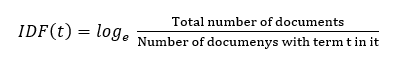

IDF: Inverse Document Frequency, which measures the importance of the words. When TF method is used, the importance of all words is considered equally. It means that some unimportant words (e.g.: ‘game’) but use frequently, will reduce the weight of some words that can represent the actual meaning of the sentence. (e.g.: 'simple'). To solve this problem, the inverse document frequency factor is introduced, which reduces the weight of entries that appear very frequently in the document set and increases the weight of the frequency of words that appear rarely. The formula is as follows:
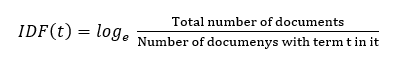

CountVectorizer and TfidfTransformer in Scikit-Learn can implement the weight calculation method of TF-IDF.

CountVectorizer class converts the morphology in the text into a word frequency matrix. For example, the matrix contains an element a [i] [j], which represents the word frequency of j words in the i type text. The keywords of all the text in the bag of words could be mentioned by using get_feature_names().the result of the word frequency matrix could be shown by doing toarray().

TfidfTransformer is used to count the TF-IDF value of each word in the vectorizer. The specific usage of each class will be explained in the code comments. 

The specific operation process is on the following web page: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [58]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [59]:
#count the number of words appears in each reviews
cv = CountVectorizer()
#count the tf-idf weight of each word
tf_idf=TfidfTransformer()
#calculate the total weight
x = tf_idf.fit_transform(cv.fit_transform(clean_review))
#get all the words
words = cv.get_feature_names()
#ge the weight
weight= x.toarray()

In [60]:
#test the data
print(weight)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Cluster the reviews

After keyword extraction, this step is used to classify the text. In this step, K-means clustering is selected, which is more commonly used in clustering algorithms and widely used when clustering large-scale data because of the higher algorithm efficiency. The goal here is to divide the text into four categories. The types of game reviews predicted here are game strategy, gaming experience, suitable age of the games, game background story introduction.

In [61]:
from sklearn.cluster import KMeans

In [62]:
#do the kmeans cluster
kms = KMeans(n_clusters=4)
#input the data
s = kms.fit(weight)

In [63]:
# ge the types of different reviews
types= (kms.labels_)
#put data to the 'types' column
data_help['types']=types

In [64]:
#test the data
data_help.head()

,posted,recommend,review,%_help,num_help,overall,text,types
0,2014,True,I know what you think when you see this title ...,75,20,1,know think see title barbie dreamhouse party i...,3
4,2015,True,I'm going to keep this somewhat short and swee...,90,31,1,m going keep somewhat short sweetat time writi...,3
5,2014,True,Love it. Love it. And since I can read cyrilli...,66,41,1,love love since read cyrillic script play rusi...,1
6,2014,True,One does not simply not buy Garry's Mod. I rec...,80,10,1,one simply buy garry mod recommend buy,1
9,2015,True,My childhood game has finally gotten onto stea...,68,41,1,childhood game finally gotten onto steam worth,1


The optimal number of K-means clusters is not calculated here. One reason is due to the excessive amount of data, the computer time for calculating the optimal number of clusters is slow,  the other reason is that the expected classification results already have.

# Store the cleaning data

Due to a large amount of data, the calculation of k-means takes time. In order to be able to directly read the processed data when it is opened next time, export the processed data to a new CSV format file.

In [65]:
# put data to new csv
data_help.to_csv('clean_review.csv',index_label='index')

In [66]:
#test data
new_data=pd.read_csv('clean_review.csv')
new_data.head()

,index,posted,recommend,review,%_help,num_help,overall,text,types
0,0,2014,True,I know what you think when you see this title ...,75,20,1,know think see title barbie dreamhouse party i...,3
1,4,2015,True,I'm going to keep this somewhat short and swee...,90,31,1,m going keep somewhat short sweetat time writi...,3
2,5,2014,True,Love it. Love it. And since I can read cyrilli...,66,41,1,love love since read cyrillic script play rusi...,1
3,6,2014,True,One does not simply not buy Garry's Mod. I rec...,80,10,1,one simply buy garry mod recommend buy,1
4,9,2015,True,My childhood game has finally gotten onto stea...,68,41,1,childhood game finally gotten onto steam worth,1


# Highest overall evaluation reviews type

The method used in this step is called 'groupby'. The groupby method can perform operations such as slicing, dicing, and summarizing the data set. At the same time, it can quickly divide the grouped data of the data frame according to user needs for calculation. The specific functions are shown in the following network： https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html

Find out the category with the highest comprehensive evaluation of reviews in total.

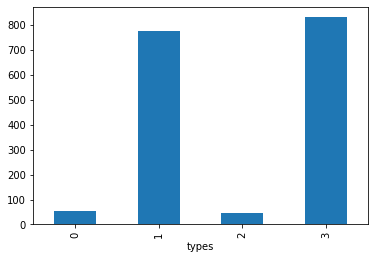

In [67]:
#group the data
#clean_review.groupby('posted').types.count()#.plot(kind='bar')
new_data.groupby('types').posted.count().plot(kind='bar')

Find out the category with the highest comprehensive evaluation of reviews each year.

In [68]:
#use group by to find types form each year, and put them to list
#2014 year
d_14=new_data.loc[new_data['posted']==2014].groupby('types').posted.count()
y_14=[i for i in d_14]

#2015 year
d_15=new_data.loc[new_data['posted']==2015].groupby('types').posted.count()
y_15=[i for i in d_15]

#2018 year
d_18=new_data.loc[new_data['posted']==2018].groupby('types').posted.count()
y_18=[i for i in d_18]

In [69]:
#bulid up a new datarame
counts={'2014':y_14,'2015':y_15,'2018':y_18}
df_counts =pd. DataFrame(counts)

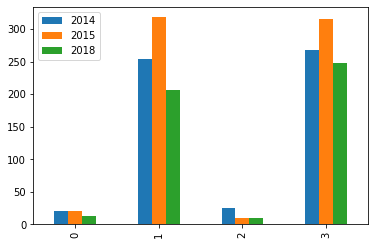

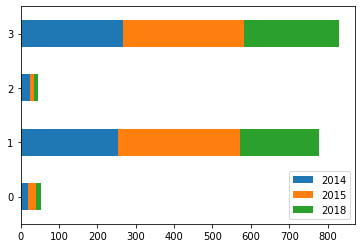

In [70]:
#show the graph
df_counts.plot.bar()
df_counts.plot.barh(stacked=True)

The type of the highest comprehensive evaluation of the evaluation is the same annually and overall

#  The instability of k-means

 Due to the instability of k-means, there may be deviations in the clustering results.
 

# Show the most popular review type content through word cloud 

The principle of the word cloud is to count the frequency of the input text data, display the vocabulary in different proportions according to the frequency of vocabulary occurrence, and generate pictures. Words with a high frequency are displayed large, and words with a low frequency are displayed small. However, it needs to install. The install link is as follows: https://pypi.org/project/wordcloud/#files
This step needs to check the version of python because my version is python3.7, download the corresponding version and install it with pop install：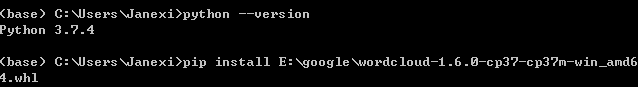

In [71]:
from wordcloud import WordCloud

Before doing the word cloud, preprocessing the data.

In [72]:
new_data=new_data.loc[new_data['types']==new_data['types'].value_counts().idxmax()]

In [73]:
#change the word to string 
word_list=df_list(new_data['text'])
str_word = " ".join(word_list)

Make a word cloud and visualize it.

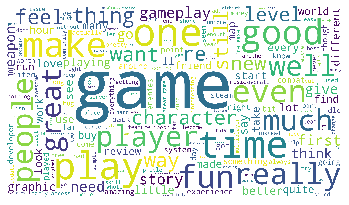

In [74]:
wordcloud = WordCloud(
    #set the background to white, the default is black
        background_color="white",
    #specify the maximum font size
        max_font_size=840, 
    #set the width of the picture
        width=4200,   
    #set the height of the picture
        height=2400,
    #set the edge of the picture
        margin=10 
    #import dataset
        ).generate(str_word)
# Draw picture
plt.imshow(wordcloud)
# Eliminate axis
plt.axis("off")
plt.show()


# Conclusion

Through the display of the word cloud, it can be found that the words which related to time (e.g.: life, time, hour) and the evaluation of whether it is a game worth playing (e.g.: want, good, great) appears more frequently in this type of reviews. As a result, it can be speculated that the type of reviews with the highest overall rating is the comment about the duration of the game.
